In [1]:
import numpy as np
from scipy.io import wavfile
from keras.models import Sequential
from keras.layers import Dense, Dropout, TimeDistributed, Conv1D, GRU, BatchNormalization, Reshape
from keras.optimizers import Adam
from IPython.display import Audio
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Introduction to audio data

First, we briefly describe what audio data look like, and how we can use it for ML applications such as keyword spotting. Below is an audio clip for the keyword we are looking for.

In [2]:
Audio("data/demo.wav")

In [3]:
rate, dat = wavfile.read("data/demo.wav")
print(rate, dat.shape[1])

44100 2


The sampling rate is 44,100 Hz, which means there are 44,100 samples in a second. Higher sampling rate better represents the real world (i.e. better resolution). It is also a stereo recording, one for left channel and one for right channel.

In [4]:
print(dat.shape[0] / rate)

10.0


The length of this audio clip is 10s.

Currently values in data represent the amplitude of the wave (i.e. loudness). The **time-domain representation** (i.e. amplitude vs time) for two channels is

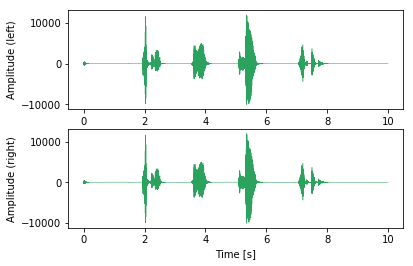

In [5]:
time = np.arange(0, dat.shape[0]) / rate
plt.figure(1)
plt.subplot(211)
plt.plot(time, dat[:, 0], color="#2ca25f", linewidth=0.5)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude (left)")
plt.subplot(212)
plt.plot(time, dat[:, 1], color="#2ca25f", linewidth=0.5)
plt.xlabel("Time [s]")
plt.ylabel('Amplitude (right)')
plt.show()

Amplitudes are not very informative, which only describes the loudness of the recording. Let's look at the **frequency-domain** representation, which indicate what frequencies are present in the recording and their corresponding magnitudes.

The recording is composed of multiple frequencies of different amplitude at each time point. To recover individual signals (i.e. sinusoids) from the composite signal, we use time window based **discrete Fourier Transform**.

Let's use 200 samples per window with stride of 120 samples to perform Fourier Transform. For illustration, I will show the left channel only.

In [6]:
spec, freqs, bins, im = plt.specgram(dat[:,0], Fs=rate, NFFT=200, noverlap=120)
cmap=plt.get_cmap()
cbar=plt.colorbar(im)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
cbar.set_label('Intensity [dB]')

Let's plot the **spectrogram**, which is the energy distribution of the signal over time and frequency. Bright color represents more active frequencies. The spectrogram can used for sequence models.

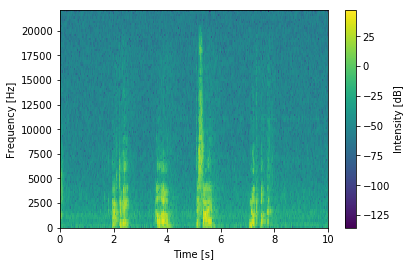

In [7]:
plt.show()

## Keyword Spotting

Since speech data may be hard to get and label, we have synthesized the training data by mixing audio clips of keywords, negative words, and background noise. In so doing, we know the exact labels. For each synthesized example, we will have
- 10 second long audio clip with different background noise at sampling rate of 44100 Hz
- 0-4 counts of keywords
- 0-2 counts of negative words
- 5511 input time steps from spectrogram with 200 samples per window and stride of 120 samples
- 1375 output time steps, labelled it as either 0 (negative) or 1 (positive). We label 1 for 50 time steps after keyword is finished. That is, $T_x \neq T_y$

In [8]:
# load training and validation dataset
X = np.load("data/X_train.npy")
Y = np.load("data/Y_train.npy")
X_val = np.load("data/X_val.npy")
Y_val = np.load("data/Y_val.npy")

### Model Architecture

The input length is larger than output length. We want input to be detailed so that we can build better models but we don't need to predict labels for very finite time steps. To get 1-to-1 input/output for RNN, we can first apply a **1D convolution** to reduce the dimension of input to the same dimension as the output.
- Filter size = 15, stride = 4
- 32 filters
- ReLU activation

Next, we apply a **unidirectional GRU**. We don't use bidirectional RNN as we want to predict label as we process signal. We don't want to wait until the whole signal is processed. We use GRU here as it trains faster.
- Dropout for input, with 80% keep probability
- Batch normalization to speed up training
- Another dropout with 80% keep probability for output

Finally, we use a **dense layer with sigmoid activation** to output binary label.

In [9]:
model = Sequential()
model.add(Conv1D(input_shape=(X.shape[1], X.shape[2]), filters=32, kernel_size=15, strides=4, activation="relu"))
model.add(GRU(units=32, return_sequences=True, dropout=0.2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(1, activation="sigmoid")))
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1375, 32)          48512     
_________________________________________________________________
gru_1 (GRU)                  (None, 1375, 32)          6240      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1375, 32)          128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1375, 32)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1375, 1)           33        
Total params: 54,913
Trainable params: 54,849
Non-trainable params: 64
_________________________________________________________________


Train the model with 80 epochs

In [11]:
loss, acc = model.evaluate(X, Y, verbose=0)
print("Epoch 0 - loss: {} - acc: {}".format(loss, acc))
epoch = 1
while epoch <= 80:
    if epoch % 10 > 0:
        model.fit(X, Y, batch_size=4, epochs=9, verbose=0)
        epoch += 9
        continue
    
    print("Epoch {}:".format(epoch))
    model.fit(X, Y, batch_size=4, epochs=1, verbose=2)
    epoch += 1

Epoch 0 - loss: 0.6625757336616516 - acc: 0.7613090991973877
Epoch 10:
Epoch 1/1
 - 8s - loss: 0.1870 - acc: 0.9408
Epoch 20:
Epoch 1/1
 - 8s - loss: 0.1570 - acc: 0.9500
Epoch 30:
Epoch 1/1
 - 8s - loss: 0.1431 - acc: 0.9548
Epoch 40:
Epoch 1/1
 - 8s - loss: 0.1441 - acc: 0.9537
Epoch 50:
Epoch 1/1
 - 8s - loss: 0.1313 - acc: 0.9544
Epoch 60:
Epoch 1/1
 - 8s - loss: 0.1249 - acc: 0.9588
Epoch 70:
Epoch 1/1
 - 8s - loss: 0.1227 - acc: 0.9602
Epoch 80:
Epoch 1/1
 - 8s - loss: 0.1147 - acc: 0.9623


Evaluate accuracy of this system on validation set

In [12]:
_, acc = model.evaluate(X_val, Y_val)
print(acc)

11/11 [==============================] - 0s 19ms/step
0.9246942400932312


### Prediction on the demo data

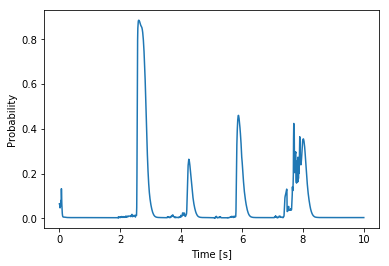

In [13]:
demo = spec.swapaxes(0, 1)
predictions = model.predict(demo.reshape(1, X.shape[1], X.shape[2]))
plt.plot(np.linspace(0, 10, Y.shape[1]), predictions.reshape(-1))
plt.xlabel("Time [s]")
plt.ylabel("Probability")
plt.show()

Indeed, keyword "activate" finished at around 2s.